In [1]:
!pip install --upgrade -i https://test.pypi.org/simple/ ddqla

Looking in indexes: https://test.pypi.org/simple/


In [2]:
import numpy as np
import pandas as pd

from ddqla.agents import BaseAgent

from keras.models import Model
from keras.layers import Dense, Input
from keras.optimizers import Adam
from keras.losses import MeanSquaredError

In [3]:
class PacchiAgent(BaseAgent):
    __ACTIONS = 4

    def __init__(self):
        super().__init__(
            num_actions=PacchiAgent.__ACTIONS,
            environment=np.asarray([0, 0], dtype=np.float32),
            fit_each_n_steps = 5,
            exploration_rate_decay = 1e-3,
            cumulative_rewards_max_length=250,
            memory_max_length=512,
            memory_batch_size=128,
        )

    def _get_model(self, state_features):
        inputs = Input(shape=(state_features))
        dense = Dense(8, activation='swish')(inputs)
        dense = Dense(8, activation='swish')(dense)
        outputs = Dense(PacchiAgent.__ACTIONS, activation='linear')(dense)

        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(), loss=MeanSquaredError())
        model.summary()

        return model

    def reset_state(self):
        self._steps += 1
        self._state = np.asarray([0, 0], dtype=np.float32)

    def _get_reward(self, action):
        reward = -1
        if action == 0 and self._state[0] == 0:  #  prendi pacco
            self._state[1] = 1 # pacco preso
        elif action == 1:  # lascia il pacco
            if self._state[1] == 1:
                self._state[1] = 0  # no pacco
                if self._state[0] == 1:
                    reward = 5  # 4 azioni per raggiungere lo scopo
        elif action == 2:  #  vai a magazzino 2
            self._state[0] = 1  # sono in magazzino 2
        elif action == 3:  # vai a magazzino 1
            self._state[0] = 0
        return reward

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_6 (Dense)             (None, 8)                 24        
                                                                 
 dense_7 (Dense)             (None, 8)                 72        
                                                                 
 dense_8 (Dense)             (None, 4)                 36        
                                                                 
Total params: 132 (528.00 Byte)
Trainable params: 132 (528.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inp

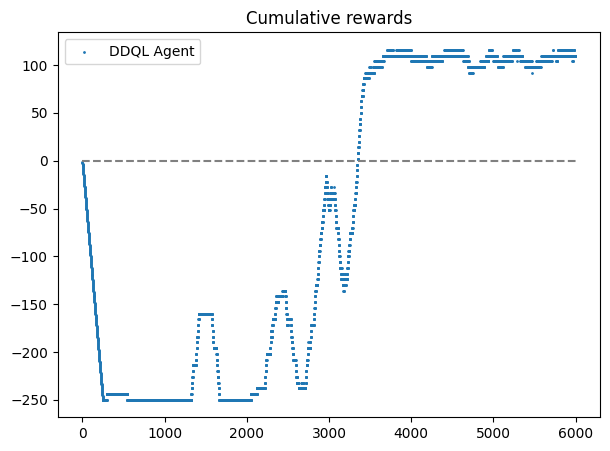

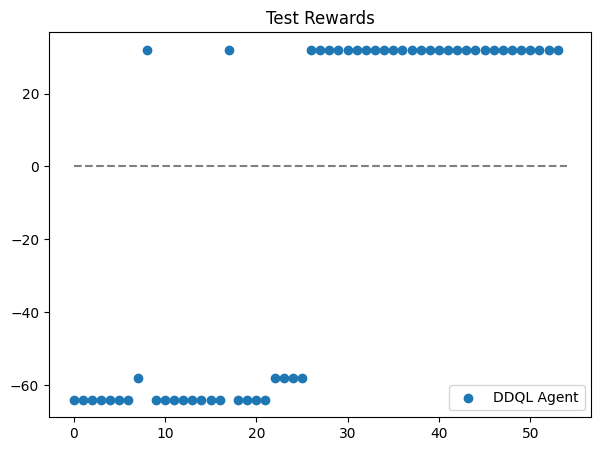

In [5]:
a = PacchiAgent()

In [5]:
a = PacchiAgent()
for s in range(0, 6000):
    a.step()
    if s % 100 == 0 and a.is_memory_ready():
        test_rewards = a.test(64)
        cum_rewards = a.get_last_cumulative_rewards()
        print("#", s, " CR: ", cum_rewards, " R: ", test_rewards)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_6 (Dense)             (None, 8)                 24        
                                                                 
 dense_7 (Dense)             (None, 8)                 72        
                                                                 
 dense_8 (Dense)             (None, 4)                 36        
                                                                 
Total params: 132 (528.00 Byte)
Trainable params: 132 (528.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inp

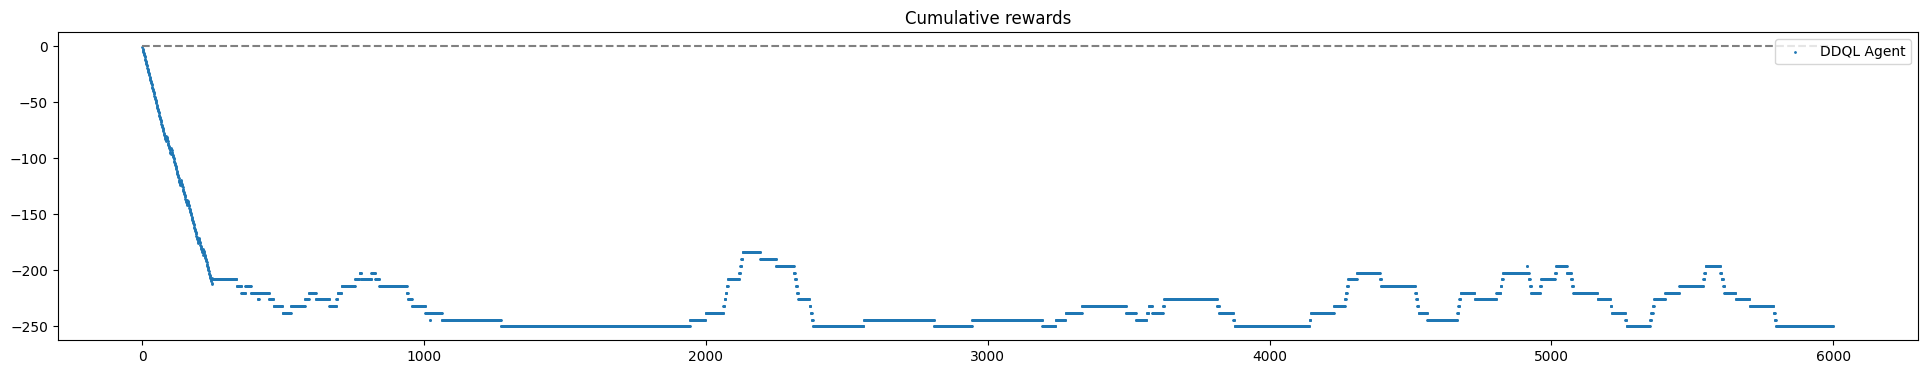

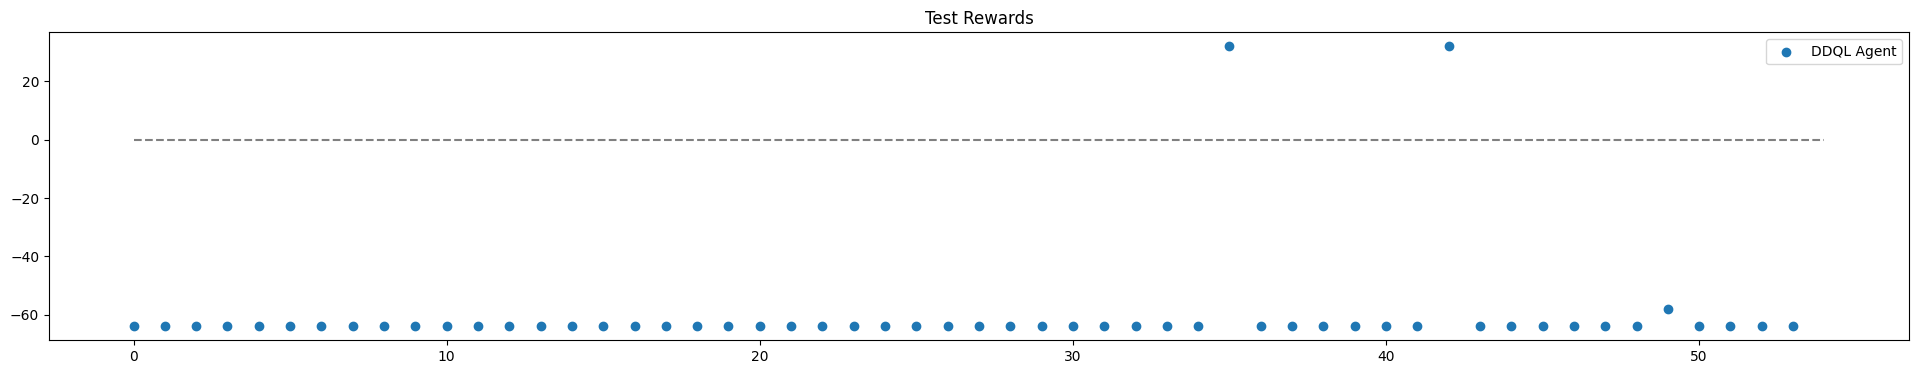

In [6]:
a.summary()

In [7]:
#il file fisicamente lo trovate nella cartella colab
a.save_simulation_log(append_ts=False)

#Legenda
- **step**: numero sequenziale dello step
- **state_x**: valore dell'ambiente nella cella di posizione x
- **p1_x**: valori assunti dal modello 1 alla posizione x
- **p2_x**: valori assunti dal modello 1 alla posizione x
- **q_x**: valori assunti dal qtable alla posizione x
- **rnd**: valore random generato in quello step, se > er usa i modelli per predirre se no sceglie un'azione randomica
- **er**: exploration rate attuale
- **action**: azione scelta
- **reward**: reward restituita per quell'azione
- **cum_reward**: reward cumulativa in quel momento

In [8]:
df = pd.read_csv("simulation_log.csv", delimiter=";")
df

,step,state_0,state_1,p1_0,p1_1,p1_2,p1_3,p2_0,p2_1,p2_2,...,q_1,q_2,q_3,rnd,er,net,action,reward,cum_reward,test
0,1,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.176742,0.999,0,3,-1,-1,NaN
1,2,1.0,0.0,-0.034896,-0.087406,0.158832,0.231526,0.170931,0.134569,0.301324,...,-0.087406,0.158832,-0.099086,0.701470,0.998,0,2,-1,-2,NaN
2,3,1.0,0.0,-0.034896,-0.087406,0.158832,0.231526,0.170931,0.134569,0.301324,...,-0.087406,0.158832,-0.099086,0.075272,0.997,0,0,-1,-3,NaN
3,4,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.516103,0.996,0,3,-1,-4,NaN
4,5,0.0,1.0,-0.036239,0.163815,0.033616,-0.117256,-0.113282,0.037316,-0.015525,...,0.037316,-0.015525,-0.117256,0.101872,0.995,0,0,-1,-5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,6050,1.0,0.0,-2.744957,-2.769425,-2.848011,-2.735457,-2.747182,-2.758869,-2.854407,...,-2.769425,-2.854407,-2.745185,0.077260,0.050,1,2,-1,-250,NaN
5996,6051,0.0,0.0,-2.728267,-2.740734,-2.740006,-2.963093,-2.744235,-2.768564,-2.735516,...,-2.768564,-2.740006,-2.963093,0.719310,0.050,1,3,-1,-250,NaN
5997,6052,1.0,0.0,-2.746152,-2.767815,-2.850762,-2.739731,-2.751531,-2.760627,-2.857581,...,-2.767815,-2.857581,-2.749404,0.895320,0.050,1,2,-1,-250,NaN
5998,6053,0.0,0.0,-2.728267,-2.740734,-2.740006,-2.963093,-2.744235,-2.768564,-2.735516,...,-2.768564,-2.740006,-2.963093,0.450414,0.050,1,3,-1,-250,NaN
